# Data loading 
Next cells are used to load the data we need.

In [41]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [42]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [43]:
unique_users, min_users, max_users = len(dataset.row.unique()), dataset.row.min(), dataset.row.max()
unique_items, min_items, max_items = len(dataset.col.unique()), dataset.col.min(), dataset.col.max()
print('users stats:',unique_users, min_users, max_users)
print('items stats:',unique_items, min_items, max_items)

users stats: 7947 0 7946
items stats: 24896 0 25974


If the difference between the unique elements and the max/min ones is really big, it's better to remap users and items in a new dataframe. In this case, it seems I can leave it as it is

In [44]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

CSR basically has a pointer to the exact beginning of every possible row. For example if i have <code>matrix.inptr = [0,1,2,4,6] </code> this means that at <code>matrix.inptr[n]</code> I have my n row which "last" until the next cell in the array. <br> In this case (for example) my third row goes from 2 to 4. <br>

What do I do with it? <br>

I use this index (2 to 4) to access the other two arrays of the crs format: <code>indices</code> and <code>data</code>.
<code>indices</code> gives me the column index and <code>data</code> gives me the actual data to take

In [45]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [46]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

The following 2 graphs plots the <code>items_per_user</code> and the <code>users_per_item</code>. It shows that slightly more than 2500 users and 2500 items have a 0 count. This is coherent with the original data we got: 30910-27255 for users and 18494-15277 for items. These differences are the missing users/items in the dataset (Basically users/items that have no interaction at all)

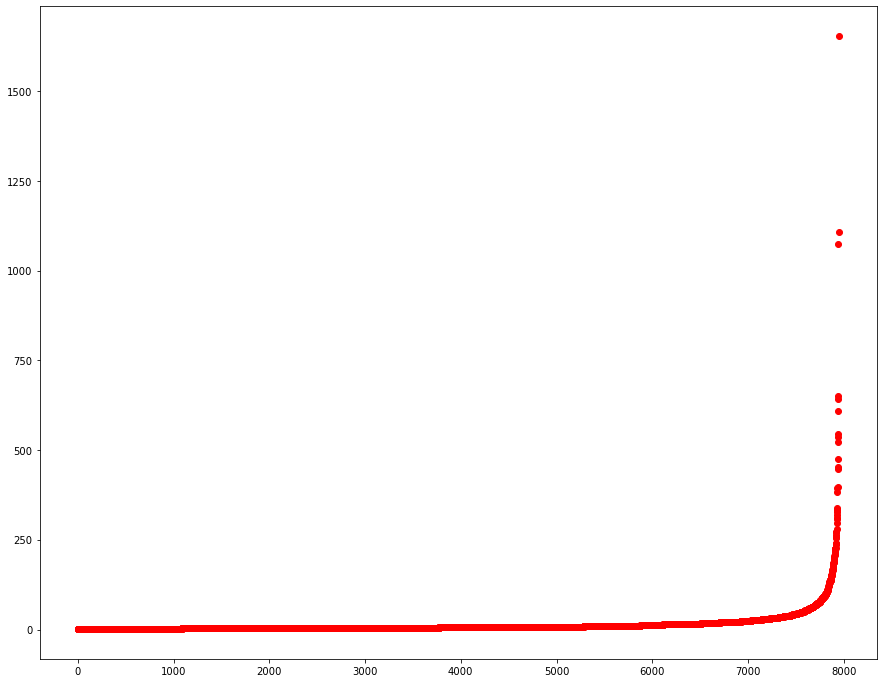

In [47]:
plt.figure(figsize=(15,12))
plt.plot(items_per_user, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

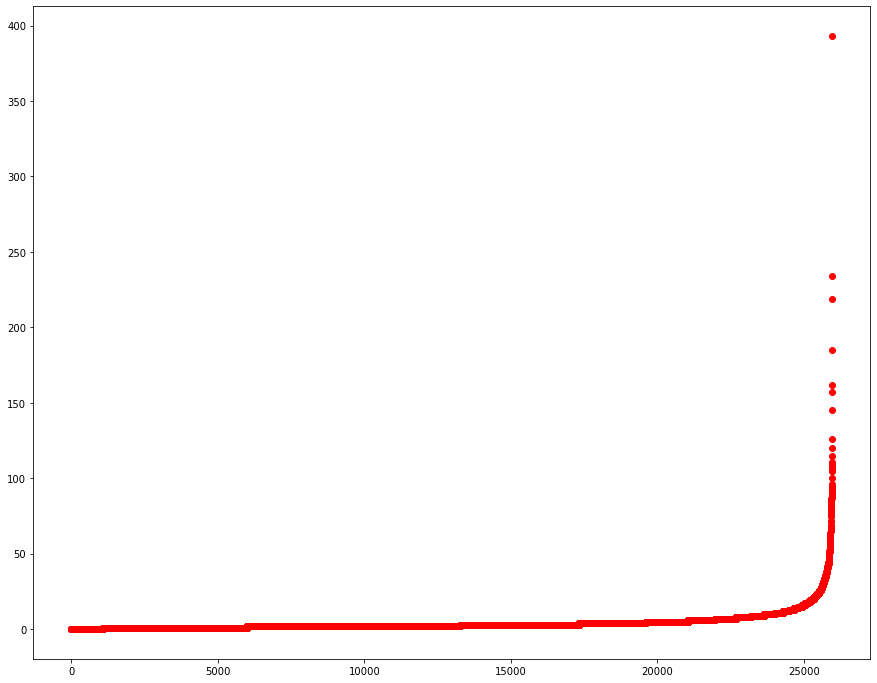

In [48]:
plt.figure(figsize=(15,12))
plt.plot(users_per_item, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

In [49]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and test. In teoria non serve, da vedere
#URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.85)



In [50]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

#evaluator for testing (the final one)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [51]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender

recommender = UserKNNCFRecommender(URM_train)

UserKNNCFRecommender: URM Detected 465 (5.85 %) cold users.
UserKNNCFRecommender: URM Detected 5732 (22.07 %) cold items.


In [64]:
x_tick = []
collaborative_MAP = []

for topK in [150, 200, 250, 300,350,400]:
    for shrink in [0,5,10,20,50,70,100,150]:
        
        x_tick.append("topk {}, shrink {}".format(topK, shrink))

        
        recommender = UserKNNCFRecommender(URM_train)
        recommender.fit(shrink=shrink, topK=topK)
    
        result_dict, _ = evaluator_validation.evaluateRecommender(recommender)
    
        collaborative_MAP.append(result_dict[10]["MAP"])

UserKNNCFRecommender: URM Detected 465 (5.85 %) cold users.
UserKNNCFRecommender: URM Detected 5732 (22.07 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 2992.67 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 3934 ( 100.00% ) in 2.42 sec. Users per second: 1626
UserKNNCFRecommender: URM Detected 465 (5.85 %) cold users.
UserKNNCFRecommender: URM Detected 5732 (22.07 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3193.39 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 3934 ( 100.00% ) in 2.40 sec. Users per second: 1638
UserKNNCFRecommender: URM Detected 465 (5.85 %) cold users.
UserKNNCFRecommender: URM Detected 5732 (22.07 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3180.61 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 3934 ( 100.00% ) in 2.41 sec. 

Similarity column 7947 ( 100 % ), 2981.46 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 3934 ( 100.00% ) in 2.56 sec. Users per second: 1538
UserKNNCFRecommender: URM Detected 465 (5.85 %) cold users.
UserKNNCFRecommender: URM Detected 5732 (22.07 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 2987.07 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 3934 ( 100.00% ) in 2.66 sec. Users per second: 1476
UserKNNCFRecommender: URM Detected 465 (5.85 %) cold users.
UserKNNCFRecommender: URM Detected 5732 (22.07 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 2851.05 column/sec, elapsed time 0.05 min
EvaluatorHoldout: Processed 3934 ( 100.00% ) in 2.75 sec. Users per second: 1432
UserKNNCFRecommender: URM Detected 465 (5.85 %) cold users.
UserKNNCFRecommender: URM Detected 5732 (22.07 %) cold items.
Unable to load Cython Compute_Similarit

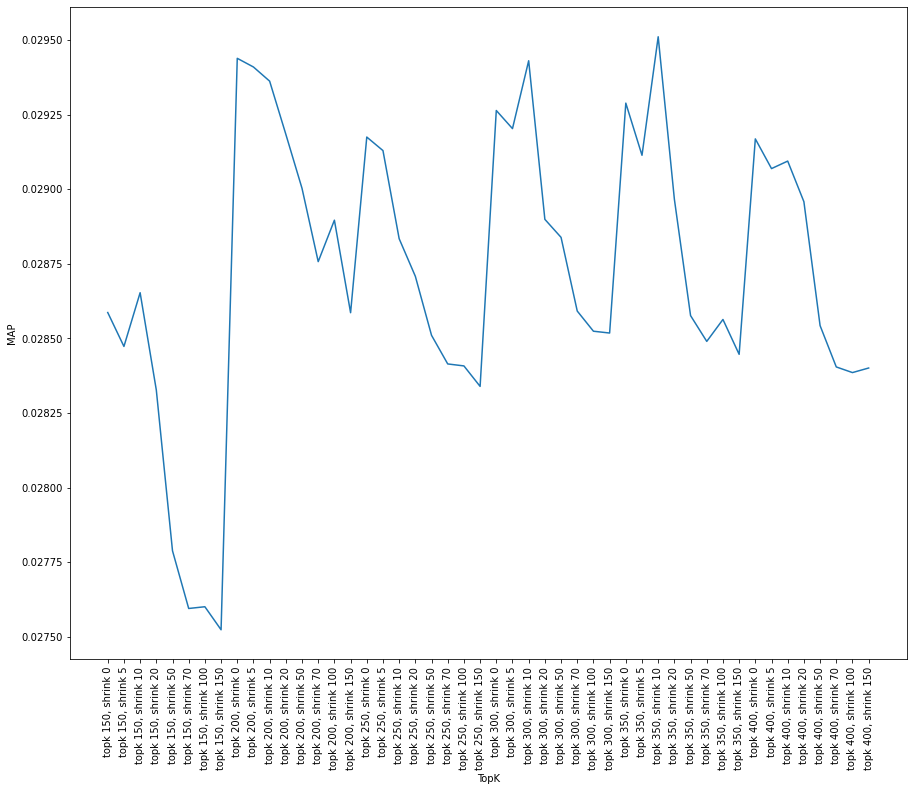

In [67]:
plt.figure(figsize=(15,12))
plt.plot(x_tick, collaborative_MAP, label="Collaborative", )
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [68]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
7939,7942
7940,7943
7941,7944
7942,7945


In [70]:
recommender = UserKNNCFRecommender(URM_train)
recommender.fit(shrink=10, topK=350)

user_id = test_users['user_id']
recommendations = recommender.recommend(user_id,cutoff = 10)


UserKNNCFRecommender: URM Detected 465 (5.85 %) cold users.
UserKNNCFRecommender: URM Detected 5732 (22.07 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 2771.53 column/sec, elapsed time 0.05 min


In [72]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

7944


In [73]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
